In [1]:
# For Data Processing
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image, ImageEnhance

# For ML Models
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import load_img

# For Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Miscellaneous
from tqdm import tqdm
import os
import random

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train_dir = r'/content/drive/MyDrive/GecDiaDiseases/Training'
test_dir = '/content/drive/MyDrive/GecDiaDiseases/Testing'

train_paths = []
train_labels = []

for label in os.listdir(train_dir):
    for image in os.listdir(train_dir+"//" +label):
        train_paths.append(train_dir + '//'+label+ '//'+image)
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

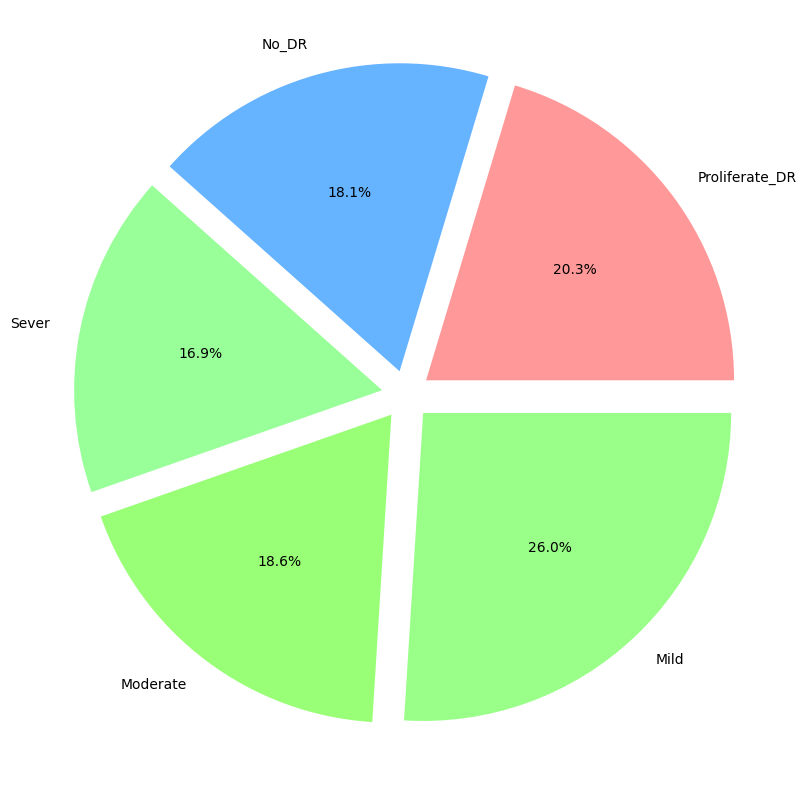

In [4]:
plt.figure(figsize=(10,10))
colors = ['#ff9999','#66b3ff','#99ff99','#99ff77','#99ff88']
plt.pie([len(os.listdir(train_dir+"//" +label))
        for label in os.listdir(train_dir)],
         labels=os.listdir(train_dir),
          colors = colors,
           explode = (0.08,0.08,0.08,0.08,0.08)
           ,autopct='%1.1f%%')
plt.show()


In [5]:
test_paths = []
test_labels = []

for label in os.listdir(test_dir):
    for image in os.listdir(test_dir+ '//' + label):
        test_paths.append(test_dir +'//'+label + '//'+image)
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

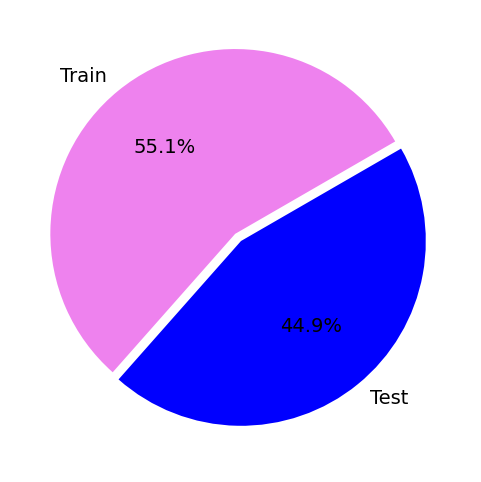

In [6]:
plt.figure(figsize=(14,6))
colors = ['Violet' , 'Blue']
plt.rcParams.update({'font.size': 14})
plt.pie([len(train_labels), len(test_labels)],
        labels=['Train','Test'],
        colors=colors, autopct='%.1f%%', explode=(0.05,0),
        startangle=30);

In [7]:
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8,1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8,1.2))
    image = ImageEnhance.Sharpness(image).enhance(random.uniform(0.8,1.2))
    image = np.array(image)/255.0
    return image

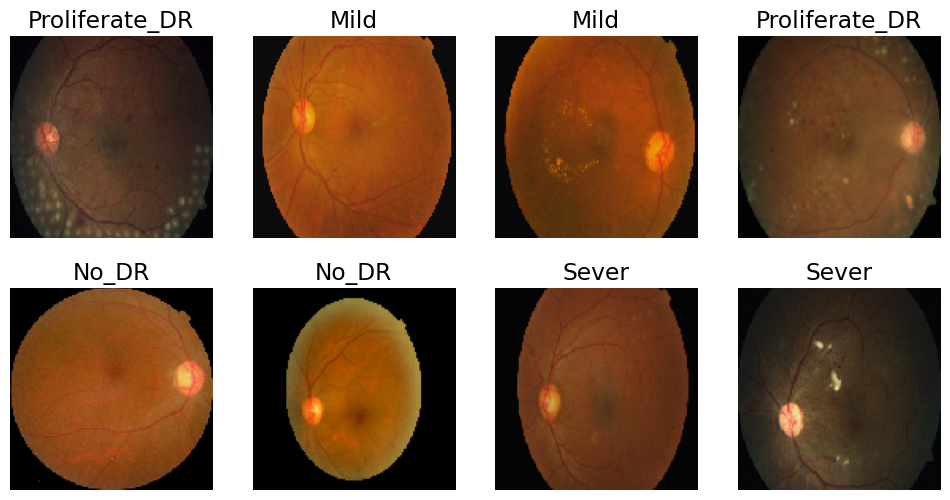

In [8]:
IMAGE_SIZE = 128


def open_images(paths):

    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)


images = open_images(train_paths[50:59])
labels = train_labels[50:59]
fig = plt.figure(figsize=(12, 6))
for x in range(1, 9):
    fig.add_subplot(2, 4, x)
    plt.axis('off')
    plt.title(labels[x])
    plt.imshow(images[x])
plt.rcParams.update({'font.size': 12})
plt.show()

In [9]:
unique_labels = os.listdir(train_dir)

def encode_label(labels):
    encoded = []
    for x in labels:
        encoded.append(unique_labels.index(x))
    return np.array(encoded)

def decode_label(labels):
    decoded = []
    for x in labels:
        decoded.append(unique_labels[x])
    return np.array(decoded)

def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for x in range(0, len(paths), batch_size):
            batch_paths = paths[x:x+batch_size]
            batch_images = open_images(batch_paths)
            batch_labels = labels[x:x+batch_size]
            batch_labels = encode_label(batch_labels)
            yield batch_images, batch_labels


In [12]:
# build inception model
base_model = ResNet50V2(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3), include_top=False, weights='imagenet')
# Set all layers to non-trainable
for layer in base_model.layers:
    layer.trainable = False
# Set the last vgg block to trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True
base_model.layers[-5].trainable = True

model = Sequential()
model.add(Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(unique_labels), activation='softmax'))

model.summary()

94668760/94668760 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 4, 4, 2048)        23564800  
                                                                 
 flatten_1 (Flatten)         (None, 32768)             0         
                                                                 
 dropout_3 (Dropout)         (None, 32768)             0         
                                                                 
 dense_3 (Dense)             (None, 128)               4194432   
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               33024     
                                                       

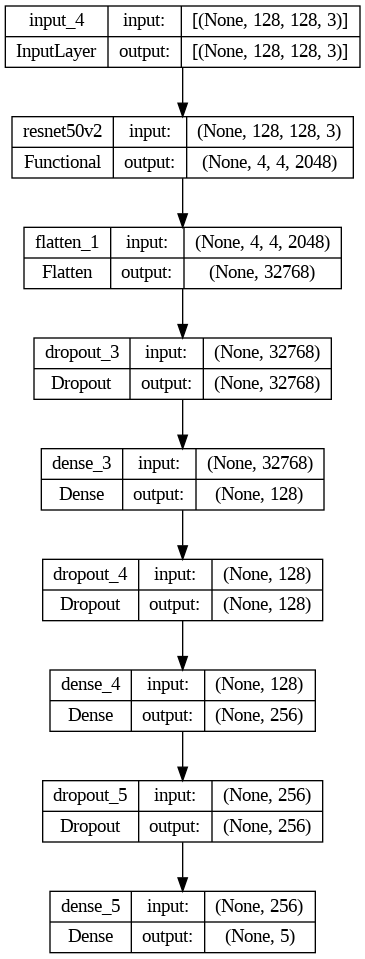

In [13]:
keras.utils.plot_model(model, show_shapes=True)

In [14]:
model.compile(optimizer=Adam(learning_rate=0.0001),
                loss='sparse_categorical_crossentropy',
                metrics=['sparse_categorical_accuracy'])

batch_size = 20
steps = int(len(train_paths)/batch_size)
epochs = 15
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

Epoch 1/15
8/8 [==============================] - 42s 5s/step - loss: 1.9012 - sparse_categorical_accuracy: 0.2875
Epoch 2/15
8/8 [==============================] - 11s 935ms/step - loss: 1.1721 - sparse_categorical_accuracy: 0.5159
Epoch 3/15
8/8 [==============================] - 9s 1s/step - loss: 0.7998 - sparse_categorical_accuracy: 0.6815
Epoch 4/15
8/8 [==============================] - 9s 1s/step - loss: 0.6244 - sparse_categorical_accuracy: 0.8089
Epoch 5/15
8/8 [==============================] - 8s 913ms/step - loss: 0.4503 - sparse_categorical_accuracy: 0.8408
Epoch 6/15
8/8 [==============================] - 9s 1s/step - loss: 0.3893 - sparse_categorical_accuracy: 0.8726
Epoch 7/15
8/8 [==============================] - 7s 910ms/step - loss: 0.2711 - sparse_categorical_accuracy: 0.9490
Epoch 8/15
8/8 [==============================] - 10s 1s/step - loss: 0.2249 - sparse_categorical_accuracy: 0.9363
Epoch 9/15
8/8 [==============================] - 9s 1s/step - loss: 0.1338 

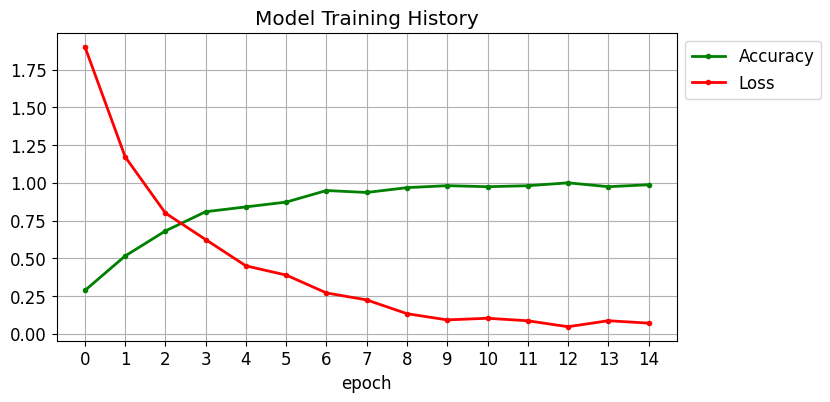

In [15]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [16]:
# Evaluate model with test data
batch_size = 32
steps = int(len(test_paths)/batch_size)
y_pred = []
y_true = []
for x,y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps):
    pred = model.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in decode_label(pred):
        y_pred.append(i)
    for i in decode_label(y):
        y_true.append(i)

  0%|          | 0/4 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step


 25%|██▌       | 1/4 [00:11<00:33, 11.29s/it]

1/1 [==============================] - 4s 4s/step


 50%|█████     | 2/4 [00:23<00:23, 11.85s/it]

1/1 [==============================] - 2s 2s/step


 75%|███████▌  | 3/4 [00:34<00:11, 11.47s/it]

1/1 [==============================] - 2s 2s/step


100%|██████████| 4/4 [00:45<00:00, 11.09s/it]

1/1 [==============================] - 2s 2s/step


5it [00:51, 10.36s/it]


In [35]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input
path='/content/drive/MyDrive/GecDiaDiseases/Testing/Moderate/00cb6555d108.png'

my_image = load_img(path, target_size=(128, 128))

#preprocess the image
my_image = img_to_array(my_image)
my_image = my_image/255
my_image = my_image.reshape((1, my_image.shape[0], my_image.shape[1], my_image.shape[2]))
#my_image = preprocess_input(my_image)
print(unique_labels,'\n')
#make the prediction
prediction = model.predict(my_image)
print(prediction,'\n')
predict_index = np.argmax(prediction)
if(predict_index==3):
    print("There is no DR")
    %matplotlib inline
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg
    img = mpimg.imread(path)
    imgplot = plt.imshow(img)
    plt.show()
else:
    print("There is a DR")

['Proliferate_DR', 'No_DR', 'Sever', 'Moderate', 'Mild'] 

1/1 [==============================] - 0s 79ms/step
[[2.1556157e-06 1.3391870e-05 2.1468634e-06 1.8860637e-05 9.9996340e-01]] 

There is a DR


The tumor is: Moderate


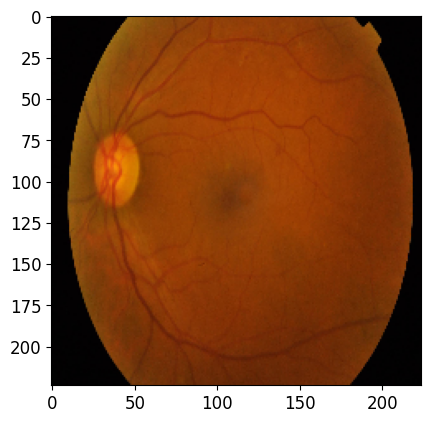

In [36]:
if(predict_index!=3):
    if(predict_index==1):
        print("The tumor is: Mild")
    elif(predict_index==2):
        print("The tumor is:Proliferate_DR ")
    elif(predict_index==0):
        print("The tumor is: Sever")
    else:
        if(predict_index==4):
            print("The tumor is: Moderate")

    %matplotlib inline
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg
    img = mpimg.imread(path)
    imgplot = plt.imshow(img)
    plt.show()

In [37]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input
path='/content/drive/MyDrive/GecDiaDiseases/Testing/Mild/00cc2b75cddd.png'

my_image = load_img(path, target_size=(128, 128))

#preprocess the image
my_image = img_to_array(my_image)
my_image = my_image/255
my_image = my_image.reshape((1, my_image.shape[0], my_image.shape[1], my_image.shape[2]))
#my_image = preprocess_input(my_image)
print(unique_labels,'\n')
#make the prediction
prediction = model.predict(my_image)
print(prediction,'\n')
predict_index = np.argmax(prediction)
if(predict_index==3):
    print("There is no DR")
    %matplotlib inline
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg
    img = mpimg.imread(path)
    imgplot = plt.imshow(img)
    plt.show()
else:
    print("There is a DR")

['Proliferate_DR', 'No_DR', 'Sever', 'Moderate', 'Mild'] 

1/1 [==============================] - 0s 125ms/step
[[3.76606360e-03 8.87736380e-01 6.44662534e-04 8.67480063e-04
  1.06985465e-01]] 

There is a DR


The tumor is: Mild


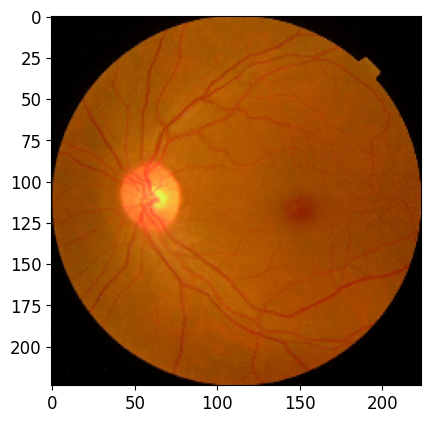

In [38]:
if(predict_index!=3):
    if(predict_index==1):
        print("The tumor is: Mild")
    elif(predict_index==2):
        print("The tumor is:Proliferate_DR ")
    elif(predict_index==0):
        print("The tumor is: Sever")
    else:
        if(predict_index==4):
            print("The tumor is: Moderate")

    %matplotlib inline
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg
    img = mpimg.imread(path)
    imgplot = plt.imshow(img)
    plt.show()

['Proliferate_DR', 'No_DR', 'Sever', 'Moderate', 'Mild'] 

1/1 [==============================] - 0s 77ms/step
[[3.39176710e-04 1.07033839e-05 1.01975274e-04 9.98193920e-01
  1.35424745e-03]] 

There is no DR


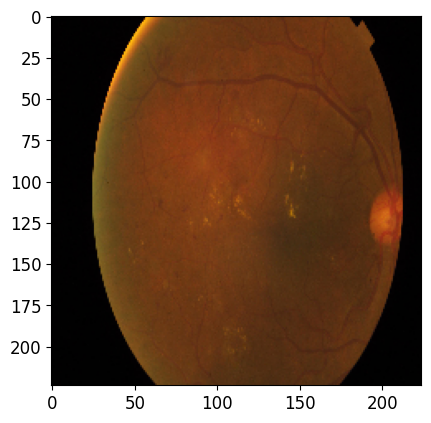

In [39]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input
path='/content/drive/MyDrive/GecDiaDiseases/Testing/No_DR/000c1434d8d7.png'

my_image = load_img(path, target_size=(128, 128))

#preprocess the image
my_image = img_to_array(my_image)
my_image = my_image/255
my_image = my_image.reshape((1, my_image.shape[0], my_image.shape[1], my_image.shape[2]))
#my_image = preprocess_input(my_image)
print(unique_labels,'\n')
#make the prediction
prediction = model.predict(my_image)
print(prediction,'\n')
predict_index = np.argmax(prediction)
if(predict_index==3):
    print("There is no DR")
    %matplotlib inline
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg
    img = mpimg.imread(path)
    imgplot = plt.imshow(img)
    plt.show()
else:
    print("There is a DR")

In [40]:
if(predict_index!=3):
    if(predict_index==1):
        print("The tumor is: Mild")
    elif(predict_index==2):
        print("The tumor is: Moderate")
    elif(predict_index==0):
        print("The tumor is: Sever")
    else:
        if(predict_index==4):
            print("The tumor is: Moderate")

    %matplotlib inline
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg
    img = mpimg.imread(path)
    imgplot = plt.imshow(img)
    plt.show()

In [41]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input
path='/content/drive/MyDrive/GecDiaDiseases/Testing/Proliferate_DR/03c85870824c.png'

my_image = load_img(path, target_size=(128, 128))

#preprocess the image
my_image = img_to_array(my_image)
my_image = my_image/255
my_image = my_image.reshape((1, my_image.shape[0], my_image.shape[1], my_image.shape[2]))
#my_image = preprocess_input(my_image)
print(unique_labels,'\n')
#make the prediction
prediction = model.predict(my_image)
print(prediction,'\n')
predict_index = np.argmax(prediction)
if(predict_index==3):
    print("There is no DR")
    %matplotlib inline
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg
    img = mpimg.imread(path)
    imgplot = plt.imshow(img)
    plt.show()
else:
    print("There is a DR")

['Proliferate_DR', 'No_DR', 'Sever', 'Moderate', 'Mild'] 

1/1 [==============================] - 0s 253ms/step
[[1.1076285e-02 3.2311458e-05 9.7962749e-01 2.4751353e-03 6.7887004e-03]] 

There is a DR


The tumor is:Proliferate_DR 


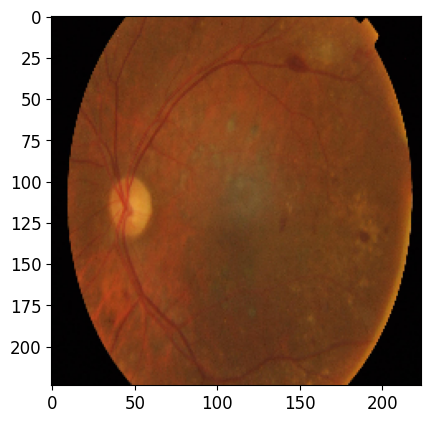

In [42]:
if(predict_index!=3):
    if(predict_index==1):
        print("The tumor is: Mild")
    elif(predict_index==2):
        print("The tumor is:Proliferate_DR ")
    elif(predict_index==0):
        print("The tumor is: Sever")
    else:
        if(predict_index==4):
            print("The tumor is: Moderate")

    %matplotlib inline
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg
    img = mpimg.imread(path)
    imgplot = plt.imshow(img)
    plt.show()

In [43]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input
path='/content/drive/MyDrive/GecDiaDiseases/Testing/Sever/02dda30d3acf.png'

my_image = load_img(path, target_size=(128, 128))

#preprocess the image
my_image = img_to_array(my_image)
my_image = my_image/255
my_image = my_image.reshape((1, my_image.shape[0], my_image.shape[1], my_image.shape[2]))
#my_image = preprocess_input(my_image)
print(unique_labels,'\n')
#make the prediction
prediction = model.predict(my_image)
print(prediction,'\n')
predict_index = np.argmax(prediction)
if(predict_index==3):
    print("There is no DR")
    %matplotlib inline
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg
    img = mpimg.imread(path)
    imgplot = plt.imshow(img)
    plt.show()
else:
    print("There is a DR")

['Proliferate_DR', 'No_DR', 'Sever', 'Moderate', 'Mild'] 

1/1 [==============================] - 0s 86ms/step
[[9.9995828e-01 2.0559930e-05 8.5834432e-07 2.0413263e-05 4.3270486e-08]] 

There is a DR


The tumor is: Sever


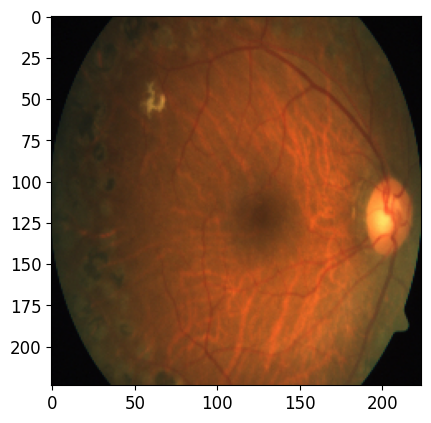

In [44]:
if(predict_index!=3):
    if(predict_index==1):
        print("The tumor is: Mild")
    elif(predict_index==2):
        print("The tumor is:Proliferate_DR ")
    elif(predict_index==0):
        print("The tumor is: Sever")
    else:
        if(predict_index==4):
            print("The tumor is: Moderate")

    %matplotlib inline
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg
    img = mpimg.imread(path)
    imgplot = plt.imshow(img)
    plt.show()